In [2]:
using Pkg
Pkg.activate("..")
using Revise
using PythonPlot,Statistics,Distributions,DataFrames,CSV,Random
PythonPlot.svg(true)
using SizeStructuredPopulations
using SpecialFunctions
include("./examples.jl")

methods(generate_cell)

# seed the random number generator for reproducibility
Random.seed!(1234);

  Activating project at `~/Dartmouth College Dropbox/Ethan Levien/RESEARCH/ACTIVE/SizeStructuredPopulations`
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.


In [1]:

model = GrowthModel(M1()...)
init = vcat([0.0], [0.0, 0.0], zeros(3))
T = 100.0
dt = 0.01
Tmax = T

function terminate(cell)
    return cell.time[end] > Tmax 
end


dfs = []
for i in 1:500
    cell = simulate_lineage(model, T, init, dt = 0.01);
    df = lineage_to_dataframe(cell);
    df.lineage = fill(i, nrow(df))
    push!(dfs,df)
end
df = vcat(dfs...);


UndefVarError: UndefVarError: `GrowthModel` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [9]:
λ = M1()[1]
df.λ .= λ_vals = [λ(collect(row)) for row in eachrow(df[:,[:x1,:x2,:x3]])];
dt = df.time[2] - df.time[1]
dfR = combine(groupby(df,:lineage),:λ => cumsum => :R,:x1 => :x1,:time => :time)
dfR.R = dfR.R *dt# condtains for each lineage T and x as a function of time

dfR.num = exp.(dfR.R).*dfR.x1
dfR.dum = exp.(dfR.R)
dfR_avg = combine(groupby(dfR,:time),
    :num => mean => :num,
    :dum => mean => :dum,
    :num => var => :num_var,
    :dum => var => :dum_var,
    [:num, :dum] => ((num, dum) -> cov(num, dum)) => :num_dum_cov,
    nrow => :n,
)
# drop cols with NaN
dfR_avg = dropmissing(dfR_avg)

Row,time,num,dum
,Float64,Float64,Float64
1,0.0,0.0,1.01005
2,0.01,0.000204388,1.0202
3,0.02,0.00138869,1.03047
4,0.03,0.00266464,1.04085
5,0.04,0.00459876,1.05136
6,0.05,0.00445879,1.06197
7,0.06,0.00566782,1.0727
8,0.07,0.00483669,1.08353
9,0.08,0.00462671,1.09447


In [10]:
dfR_avg = dfR_avg[dfR_avg.time .< 500,:]

Row,time,num,dum
,Float64,Float64,Float64
1,0.0,0.0,1.01005
2,0.01,0.000204388,1.0202
3,0.02,0.00138869,1.03047
4,0.03,0.00266464,1.04085
5,0.04,0.00459876,1.05136
6,0.05,0.00445879,1.06197
7,0.06,0.00566782,1.0727
8,0.07,0.00483669,1.08353
9,0.08,0.00462671,1.09447


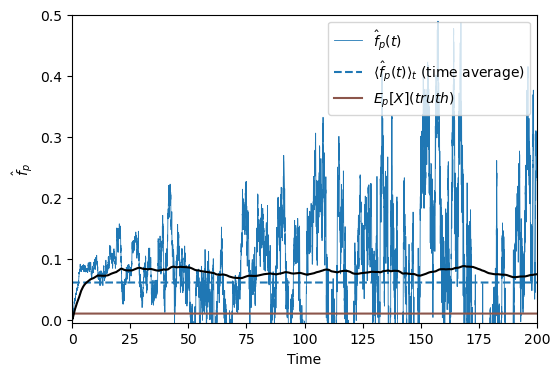

In [15]:
fig,ax = subplots(figsize=(6,4))
u = dfR_avg.num ./ dfR_avg.dum
u_var = dfR_avg.num_var ./ dfR_avg.n ./ dfR_avg.dum.^2 .+
    (dfR_avg.num.^2 .* dfR_avg.dum_var) ./ (dfR_avg.n .* dfR_avg.dum.^4) .-
    2 .* dfR_avg.num .* dfR_avg.num_dum_cov ./ (dfR_avg.n .* dfR_avg.dum.^3)
u_se = sqrt.(max.(u_var, 0))

window_mean(vals) = begin
    cleaned = collect(skipmissing(replace(vals, NaN => missing)))
    isempty(cleaned) ? NaN : mean(cleaned)
end

ax.plot(dfR_avg.time,u,"C0-",alpha=1,lw=0.6,label=L"$\hat{f}_p(t)$")
ax.fill_between(dfR_avg.time, u .- u_se, u .+ u_se, color="C0", alpha=0.2, label=L"$\hat{f}_p(t) \pm 1\mathrm{SE}$")
ax.plot(dfR_avg.time,ones(length(u)).*mean(skipmissing(replace(u, NaN => missing))),"C0--",label=L"$\langle \hat{f}_p(t) \rangle_t$ (time average)")
ax.plot(dfR_avg.time,ones(length(u))*0.01/1,"C5-",label=L"$E_p[X] (truth)$")
# average u over moving window
window_times = [50.0, 100.0, 200.0]
window_steps = max.(1, round.(Int, window_times ./ dt))
for (window_time, window_step) in zip(window_times, window_steps)
    u_avg = [window_mean(u[max(1,i-window_step+1):i]) for i in 1:length(u)]
    ax.plot(dfR_avg.time,u_avg,label="window = $(window_time)")
end
ax.set_xlim(-0.1,200)
ax.set_ylim([-0.005,0.5])
ax.set_xlabel("Time")
ax.set_ylabel(L"$\hat{f}_p$")
ax.legend(loc="upper right")
savefig("./fig4.pdf")


fig